# Import Libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Load Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-and-colon-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip lung-and-colon-cancer-histopathological-images.zip -d /content/lung_colon_image_set

Streaming output truncated to the last 5000 lines.
  inflating: /content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: /content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: /content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: /content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: /content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: /content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: /content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: /content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: /content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lu

In [ ]:
# Define the directory containing the image data
data_dir = '/content/lung_colon_image_set/lung_colon_image_set'

# Initialize empty lists to store file paths and corresponding labels
filepaths = []
labels = []

# List all the subdirectories (folds) within the main data directory
folds = os.listdir(data_dir)

# Iterate through each fold (subdirectory)
for fold in folds:
    # Create the full path to the current fold
    foldpath = os.path.join(data_dir, fold)
    
    # List all the categories within the current fold
    flist = os.listdir(foldpath)

    # Iterate through each category (e.g., colon_aca, colon_n, etc.)
    for f in flist:
        # Create the full path to the current category
        f_path = os.path.join(foldpath, f)
        
        # List all the image files within the current category
        filelist = os.listdir(f_path)

        # Iterate through each image file
        for file in filelist:
            # Create the full path to the current image file
            fpath = os.path.join(f_path, file)
            
            # Append the image file path to the list
            filepaths.append(fpath)

            # Determine the label based on the folder name and append to the labels list
            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')
            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')
            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')
            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')
            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Convert lists of file paths and labels into pandas Series
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

# Concatenate the file paths and labels into a single DataFrame
df = pd.concat([Fseries, Lseries], axis=1)


# Data Preprocessing

In [ ]:
df.head()

filepaths  \
0  /content/lung_colon_image_set/lung_colon_image...   
1  /content/lung_colon_image_set/lung_colon_image...   
2  /content/lung_colon_image_set/lung_colon_image...   
3  /content/lung_colon_image_set/lung_colon_image...   
4  /content/lung_colon_image_set/lung_colon_image...   

                         labels  
0  Lung Squamous Cell Carcinoma  
1  Lung Squamous Cell Carcinoma  
2  Lung Squamous Cell Carcinoma  
3  Lung Squamous Cell Carcinoma  
4  Lung Squamous Cell Carcinoma

In [ ]:
filepaths[0:5]

['/content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1142.jpeg',
 '/content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc838.jpeg',
 '/content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc3248.jpeg',
 '/content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1778.jpeg',
 '/content/lung_colon_image_set/lung_colon_image_set/lung_image_sets/lung_scc/lungscc4064.jpeg']

In [ ]:
labels[0:5]

['Lung Squamous Cell Carcinoma',
 'Lung Squamous Cell Carcinoma',
 'Lung Squamous Cell Carcinoma',
 'Lung Squamous Cell Carcinoma',
 'Lung Squamous Cell Carcinoma']

In [ ]:
set(labels)

{'Colon Adenocarcinoma',
 'Colon Benign Tissue',
 'Lung Adenocarcinoma',
 'Lung Benign Tissue',
 'Lung Squamous Cell Carcinoma'}

In [ ]:
df.isnull().sum()

filepaths    0
labels       0
dtype: int64

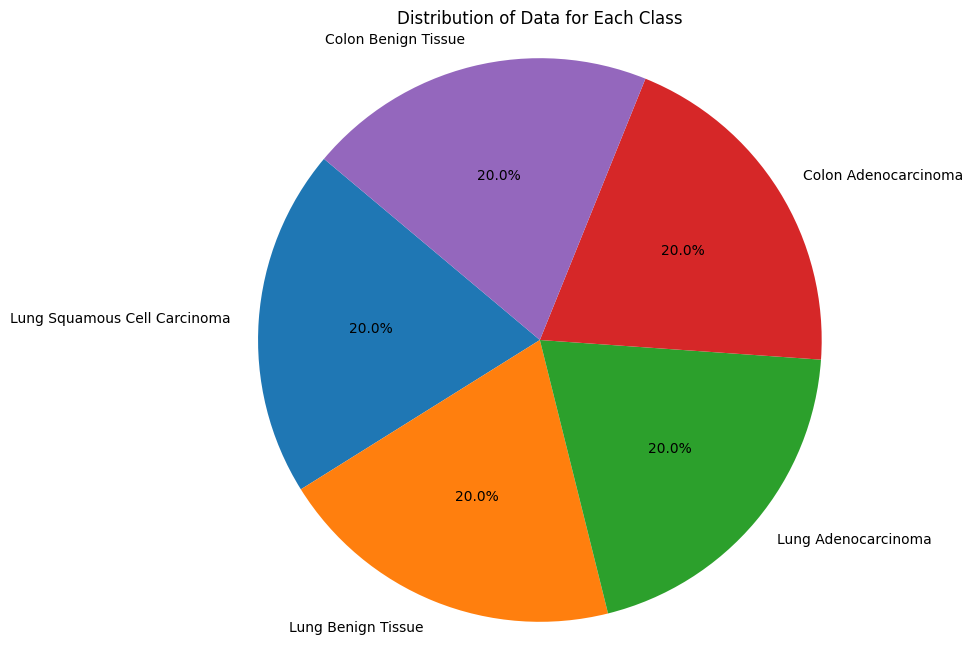

In [ ]:
# counting the occurrences of each label
label_counts = df['labels'].value_counts()

# creating a pie chart based on the data count for each class
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Data for Each Class')
plt.axis('equal')
plt.show()

# Split data into train, valid and test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, dummy_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'], shuffle=True)

valid_df, test_df = train_test_split(dummy_df, test_size=0.5, random_state=42, stratify=dummy_df['labels'], shuffle=True)

In [ ]:
print(f'Train size: {len(train_df)}')
print(f'Valid size: {len(valid_df)}')
print(f'Test size: {len(test_df)}')

Train size: 20000
Valid size: 2500
Test size: 2500


In [ ]:
print('Train')
print(train_df['labels'].value_counts())
print('Valid')
print(valid_df['labels'].value_counts())
print('Test')
print(test_df['labels'].value_counts())

Train
labels
Colon Benign Tissue             4000
Lung Benign Tissue              4000
Colon Adenocarcinoma            4000
Lung Adenocarcinoma             4000
Lung Squamous Cell Carcinoma    4000
Name: count, dtype: int64
Valid
labels
Lung Adenocarcinoma             500
Lung Squamous Cell Carcinoma    500
Colon Adenocarcinoma            500
Lung Benign Tissue              500
Colon Benign Tissue             500
Name: count, dtype: int64
Test
labels
Lung Benign Tissue              500
Colon Benign Tissue             500
Lung Squamous Cell Carcinoma    500
Lung Adenocarcinoma             500
Colon Adenocarcinoma            500
Name: count, dtype: int64


In [ ]:
train_df.head()

filepaths               labels
21495  /content/lung_colon_image_set/lung_colon_image...  Colon Benign Tissue
6818   /content/lung_colon_image_set/lung_colon_image...   Lung Benign Tissue
5011   /content/lung_colon_image_set/lung_colon_image...   Lung Benign Tissue
9185   /content/lung_colon_image_set/lung_colon_image...   Lung Benign Tissue
20274  /content/lung_colon_image_set/lung_colon_image...  Colon Benign Tissue

In [ ]:
valid_df.head()

filepaths  \
12305  /content/lung_colon_image_set/lung_colon_image...   
4067   /content/lung_colon_image_set/lung_colon_image...   
15193  /content/lung_colon_image_set/lung_colon_image...   
826    /content/lung_colon_image_set/lung_colon_image...   
1638   /content/lung_colon_image_set/lung_colon_image...   

                             labels  
12305           Lung Adenocarcinoma  
4067   Lung Squamous Cell Carcinoma  
15193          Colon Adenocarcinoma  
826    Lung Squamous Cell Carcinoma  
1638   Lung Squamous Cell Carcinoma

In [ ]:
test_df.head()

filepaths  \
5441   /content/lung_colon_image_set/lung_colon_image...   
22937  /content/lung_colon_image_set/lung_colon_image...   
3472   /content/lung_colon_image_set/lung_colon_image...   
5710   /content/lung_colon_image_set/lung_colon_image...   
14118  /content/lung_colon_image_set/lung_colon_image...   

                             labels  
5441             Lung Benign Tissue  
22937           Colon Benign Tissue  
3472   Lung Squamous Cell Carcinoma  
5710             Lung Benign Tissue  
14118           Lung Adenocarcinoma

# Data Augmentation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [40]:
BATCH_SIZE=32
IMG_SIZE= 128

# Define the number of channels in the images
channels=3
img_shape = (IMG_SIZE, IMG_SIZE, channels)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,      # Reduced rotation range
    width_shift_range=0.1,  # Reduced width shift
    height_shift_range=0.1, # Reduced height shift
    shear_range=0.1,        # Reduced shear range
    zoom_range=0.1,         # Reduced zoom range
    horizontal_flip=True    # Horizontal flip
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


# Show Samples from Train Data

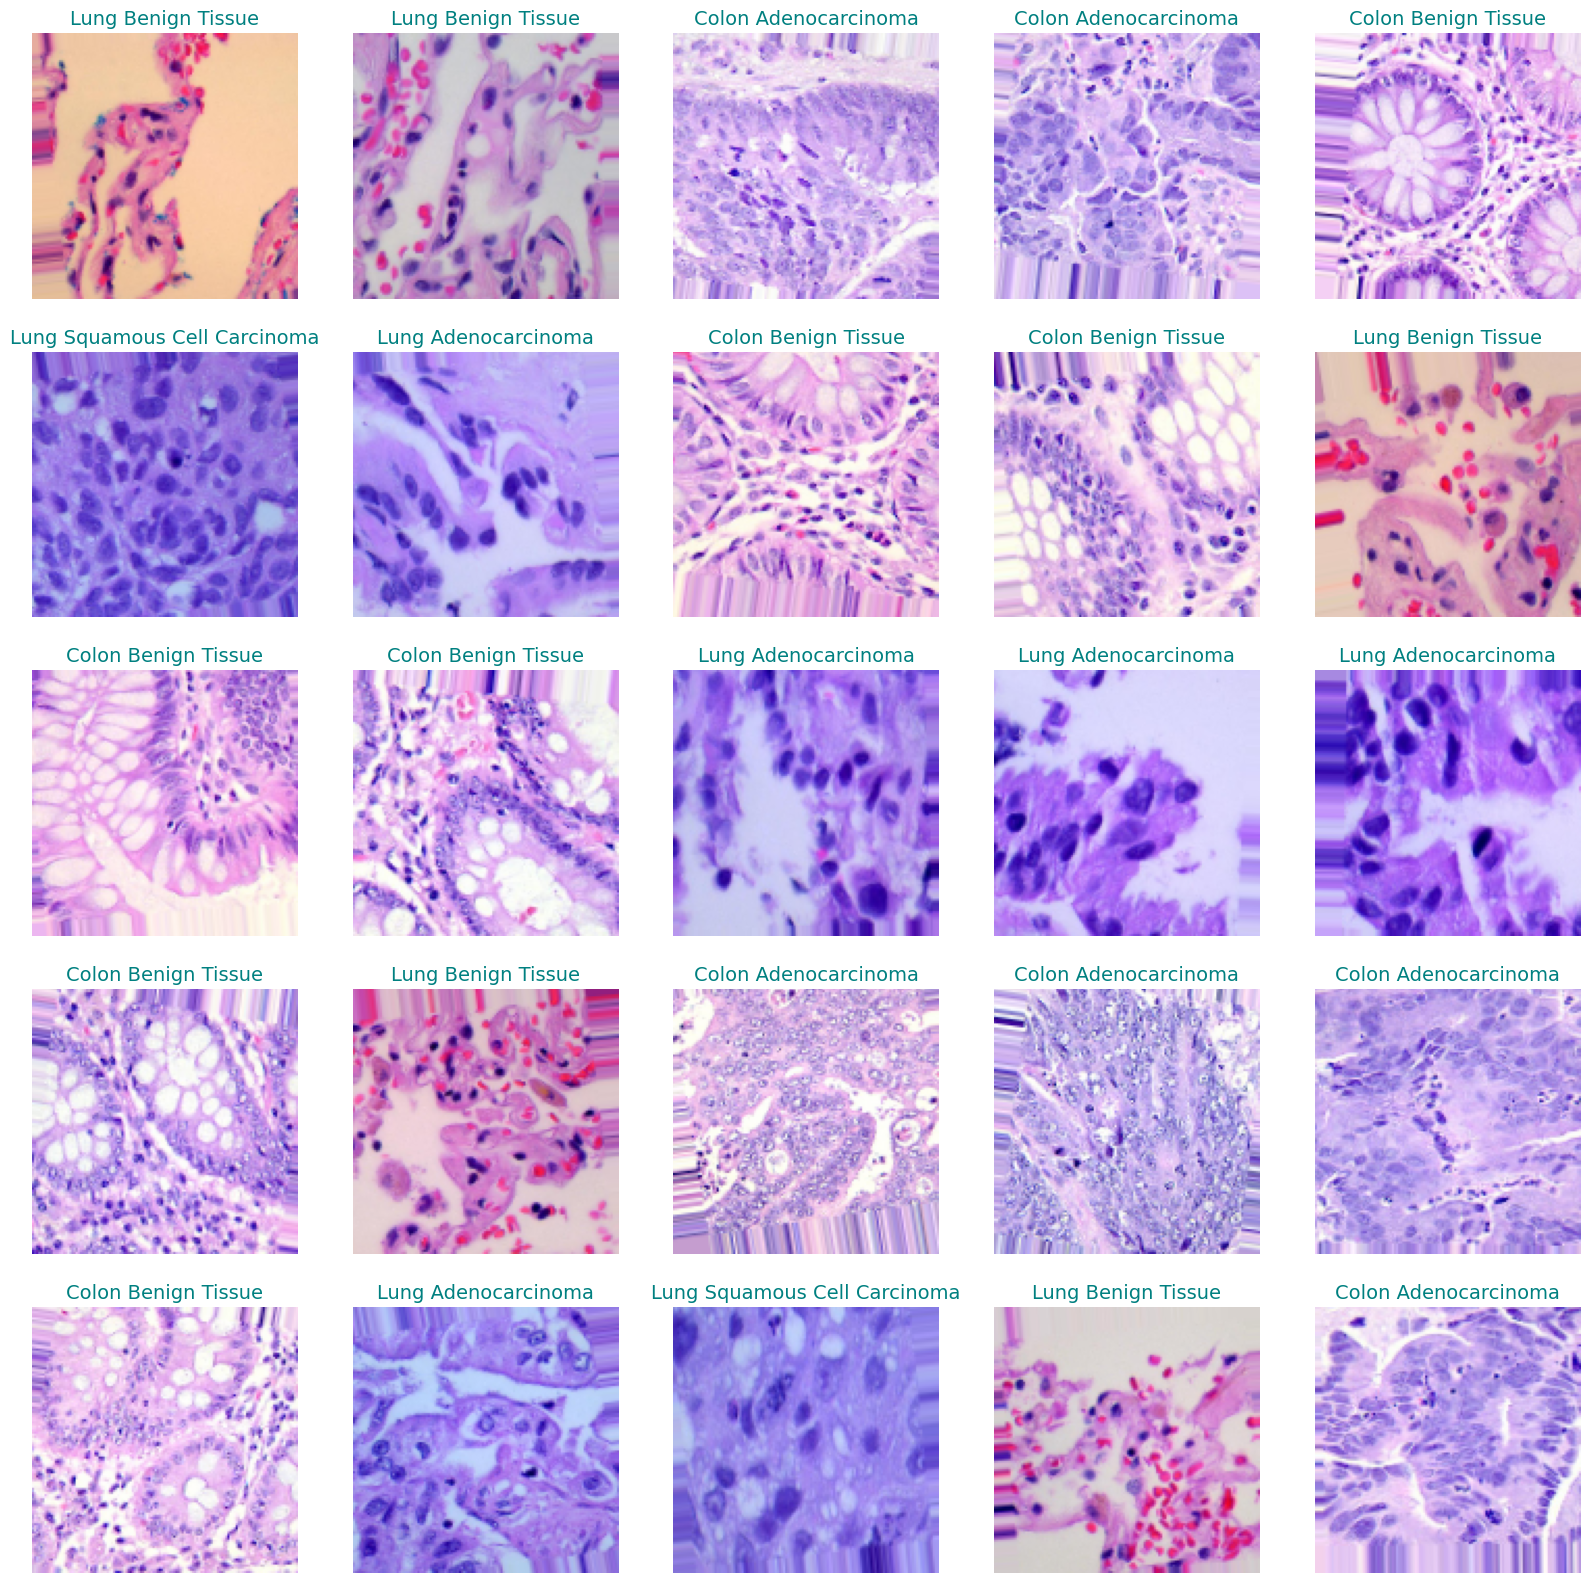

In [41]:
def image_grid(generator):
    class_indices = generator.class_indices
    classes = list(class_indices.keys())

    # Iterate through the generator to extract batches
    for images, labels in generator:
        plt.figure(figsize=(20, 20))

        # Determine the number of images to display (maximum 25)
        num_images = min(len(labels), 25)

        for i in range(num_images):
            plt.subplot(5, 5, i + 1)
            plt.imshow(images[i])

            # Get the class name using the label index
            class_index = np.argmax(labels[i])
            class_name = classes[class_index]

            plt.title(class_name, color='teal', fontsize=14)
            plt.axis('off')

        plt.show()
        # Break after displaying one batch
        break

# Call the function to display a grid of images
image_grid(train_generator)

# Model Structure

In [42]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [43]:
class_count = len(list(train_generator.class_indices.keys()))

model = Sequential(
    [
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,944,325 (49.38 MB)

 Trainable params: 12,942,853 (49.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [46]:
history = model.fit(
    x= train_generator,
    steps_per_epoch=len(train_generator),
    epochs= 10,
    verbose= 1,
    validation_data= test_generator,
    callbacks= None,
    validation_steps= None,
    shuffle= False
    )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 245ms/step - accuracy: 0.7942 - loss: 0.5867 - val_accuracy: 0.4584 - val_loss: 3.4068
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4584 - val_loss: 3.4068
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 249ms/step - accuracy: 0.8894 - loss: 0.2937 - val_accuracy: 0.7164 - val_loss: 1.5453
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7164 - val_loss: 1.5453
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 245ms/step - accuracy: 0.9225 - loss: 0.2071 - val_accuracy: 0.8144 - val_loss: 0.6522
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8144 - val_loss: 0.6522
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 242ms/step - accuracy: 0.9353 - loss: 0.1741 - val_accuracy: 0.8316 - val_loss: 0.7751
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8316 - val_loss: 0.7751
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 244ms/step - accuracy

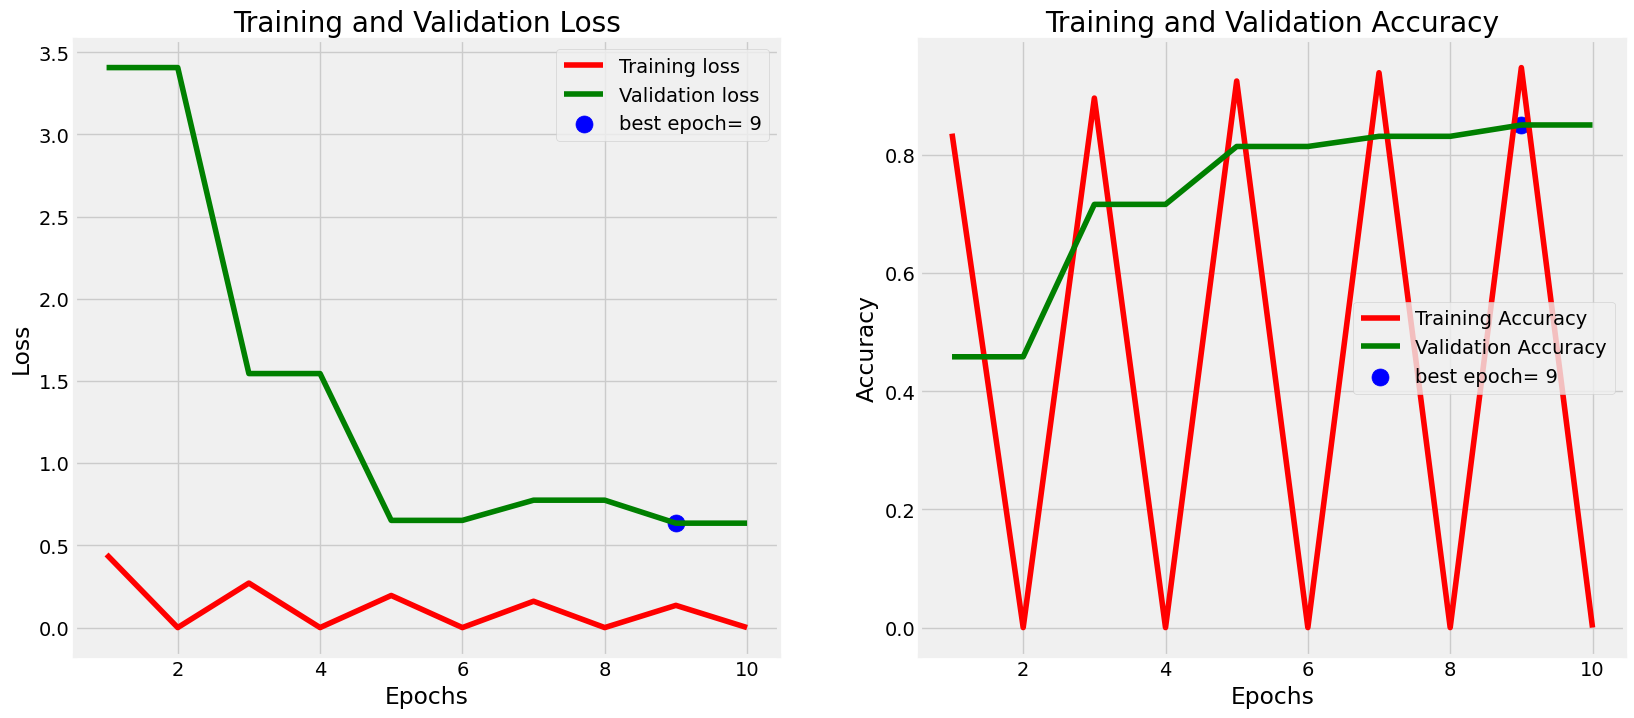

In [47]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate Model

In [48]:
train_score = model.evaluate(train_generator)
valid_score = model.evaluate(val_generator)
test_score = model.evaluate(test_generator)

625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 226ms/step - accuracy: 0.8303 - loss: 0.7264
 1/79 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9688 - loss: 0.1565

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.8497 - loss: 0.6007
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8494 - loss: 0.6799


In [49]:
print(f'Train Loss : {train_score[0]:.4f}')
print(f'Train Accuracy : {train_score[1] * 100:.2f}%')

print(f'Valid Loss : {valid_score[0]:.4f}')
print(f'Valid Accuracy : {valid_score[1] * 100:.2f}%')

print(f'Test Loss : {test_score[0]:.4f}')
print(f'Test Accuracy : {test_score[1] * 100:.2f}%')

Train Loss : 0.7221
Train Accuracy : 82.96%
Valid Loss : 0.6604
Valid Accuracy : 84.00%
Test Loss : 0.6352
Test Accuracy : 85.08%


# Prediction

In [50]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step


In [51]:
predictions

array([[3.66582572e-05, 1.20104460e-05, 1.05821330e-03, 9.78796124e-01,
        2.00969633e-02],
       [1.47094852e-06, 9.99998569e-01, 6.53365317e-09, 1.08690446e-09,
        5.03389241e-09],
       [1.49714178e-03, 5.99360683e-05, 7.16468170e-02, 7.12158283e-07,
        9.26795423e-01],
       ...,
       [1.03741313e-05, 1.25552488e-05, 7.51746193e-05, 9.99877095e-01,
        2.47640146e-05],
       [2.58270734e-06, 9.82218893e-08, 1.03717475e-07, 3.58893221e-10,
        9.99997258e-01],
       [5.19764671e-06, 1.34428328e-05, 8.84354055e-01, 1.00959130e-01,
        1.46680484e-02]], dtype=float32)

In [52]:
y_pred

array([3, 1, 4, ..., 3, 4, 2])

# Confusion Matrix

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

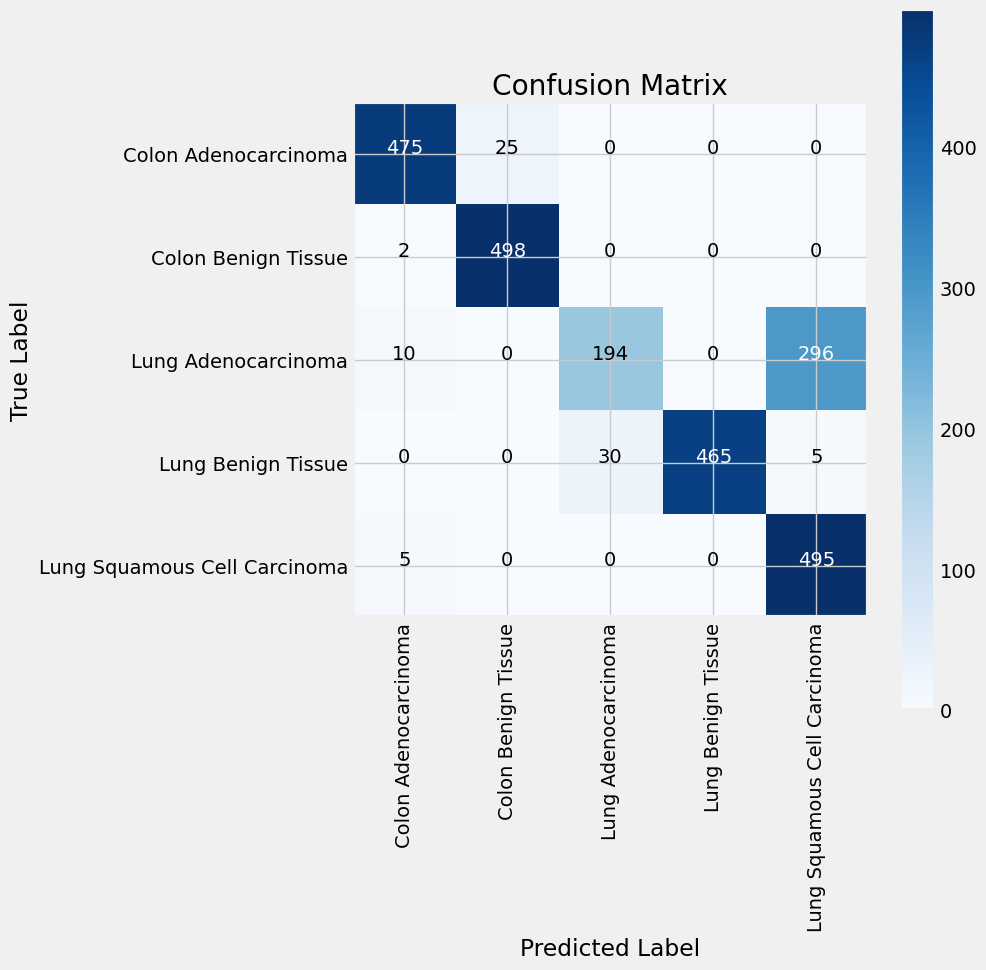

In [54]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [55]:
print(classification_report(y_true, y_pred, target_names=classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.97      0.95      0.96       500
         Colon Benign Tissue       0.95      1.00      0.97       500
         Lung Adenocarcinoma       0.87      0.39      0.54       500
          Lung Benign Tissue       1.00      0.93      0.96       500
Lung Squamous Cell Carcinoma       0.62      0.99      0.76       500

                    accuracy                           0.85      2500
                   macro avg       0.88      0.85      0.84      2500
                weighted avg       0.88      0.85      0.84      2500



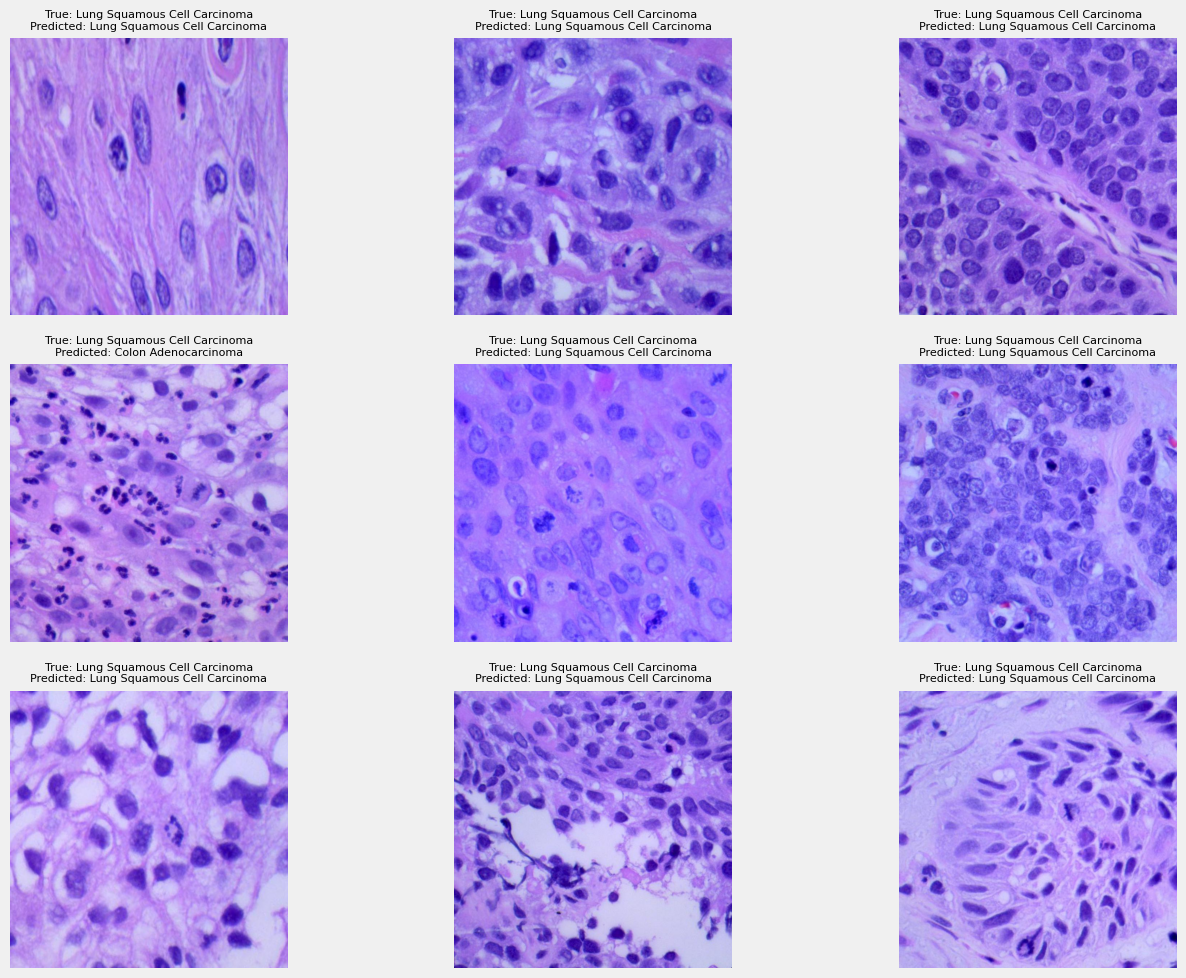

In [56]:
misclassified_indices = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
misclassified_images = [filepaths[i] for i in misclassified_indices if i < len(filepaths)]
misclassified_labels = [labels[i] for i in misclassified_indices if i < len(labels)]
misclassified_predictions = [classes[i] for i in y_pred[misclassified_indices] if i < len(classes)]

plt.figure(figsize=(15, 10))
for i in range(9):
    if i >= len(misclassified_images):
        break
    img = cv2.imread(misclassified_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {misclassified_labels[i]}\nPredicted: {misclassified_predictions[i]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [57]:
model.save('model.h5')